Tutorial 3: Realism and Complexity
==================================

In the previous two tutorials, we fitted a fairly crude and unrealistic model: the lens's mass was spherical, as was
the source's light. Given most lens galaxies are literally called 'elliptical galaxies' we should probably model their
mass as elliptical! Furthermore, we have completely omitted the lens galaxy's light, which in real observations
outshines the source's light and therefore must be included in the lens model.

In this tutorial, we'll use a more realistic lens model, which is close to the base model adopted by the example
scripts throughout the `autolens_workspace`. This model consists of the following light and mass profiles:

 - An `EllSersic` light profile for the lens galaxy's light [7 parameters].
 - A `EllIsothermal` mass profile for the lens galaxy's mass [5 parameters].
 - An `ExternalShear` which accounts for additional lensing by other galaxies nearby the lens [2 parameters].
 - An `EllExponential` light profile for the source-galaxy's light (this is probably still too simple for most
 strong lenses, but we will worry about that later) [6 parameters].

This lens model has 20 free parameters, meaning that the parameter space and likelihood function it defines has a
dimensionality of N=20. This is over double the number of parameters and dimensions of the models we fitted in the
previous tutorials and in in future exercises, we will fit even more complex models with some 30+ parameters.

Therefore, take note, as we make our lens model more realistic, we also make its parameter space more complex, this is
an important concept to keep in mind for the remainder of this chapter!

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

we'll use new strong lensing data, where:

 - The lens galaxy's light is an `EllSersic`.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllExponential`.

In [2]:
dataset_name = "light_sersic__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

__Masking__

We'll create and use a 2.5" `Mask2D`, which is slightly smaller than the masks we used in previous tutorials.

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=2.5
)

imaging = imaging.apply_mask(mask=mask)

When plotted, the lens light`s is clearly visible in the centre of the image.

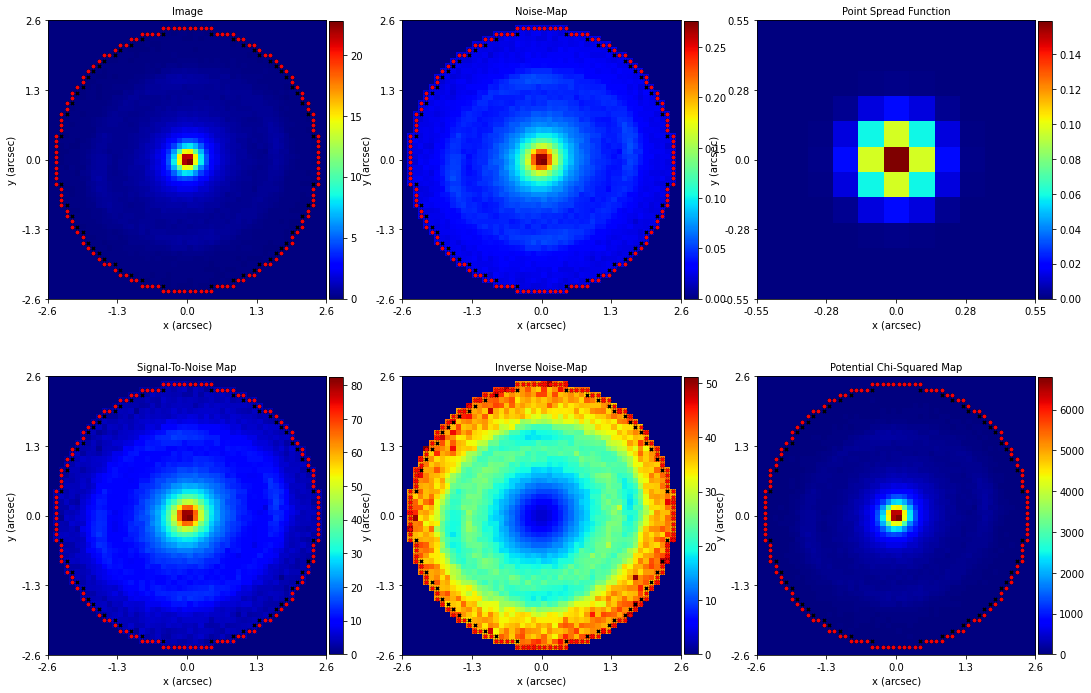

In [4]:
imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Model + Search + Analysis__

Now lets fit the dataset using a search.

In [5]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=0.5,
            bulge=al.lp.EllSersic,
            mass=al.mp.EllIsothermal,
            shear=al.mp.ExternalShear,
        ),
        source=af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllExponential),
    )
)

search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_2"),
    name="tutorial_3_realism_and_complexity",
    nlive=80,
    number_of_cores=1,
)

analysis = al.AnalysisImaging(dataset=imaging)

print(
    "Dynesty has begun running - checkout the autolens_workspace/output/howtolens/chapter_2/tutorial_3_realism_and_complexity"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result = search.fit(model=model, analysis=analysis)

print("Dynesty has finished run - you may now continue the notebook.")

INFO:root:tutorial_3_realism_and_complexity already completed, skipping non-linear search.


Dynesty has begun running - checkout the autolens_workspace/output/howtolens/chapter_2/tutorial_3_realism_and_complexity folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


__Result__

And lets look at how well the model fits the imaging data, which as we are used to fits the data brilliantly!

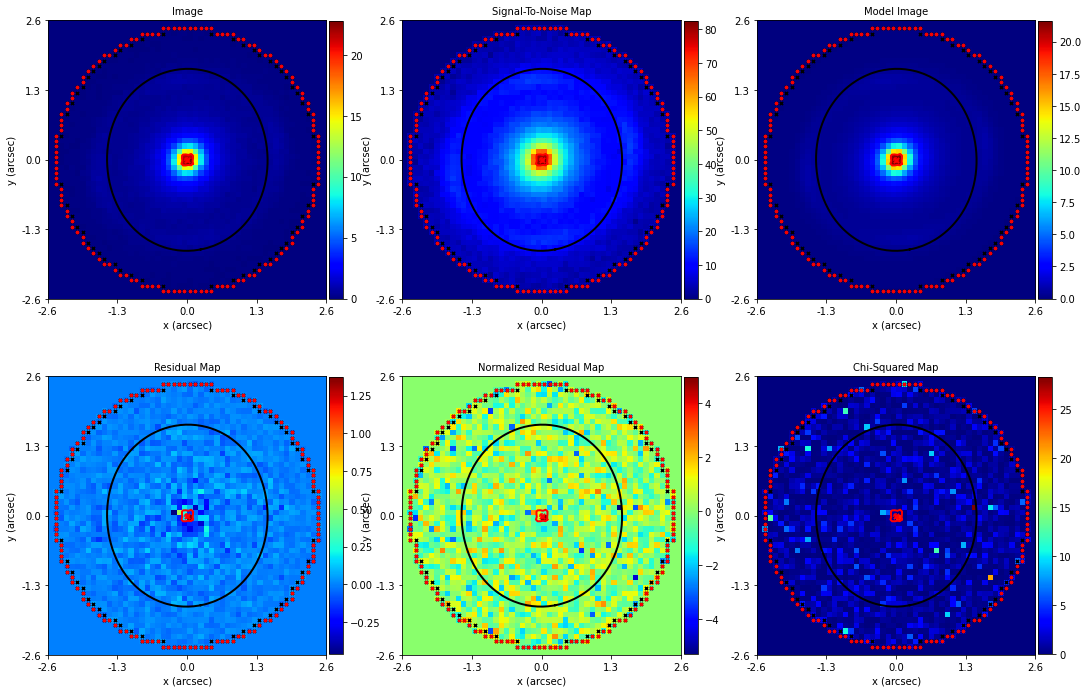

In [6]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

__Global and Local Maxima__

Up to now, all of our non-linear searches have been successes. They find a lens model that provides a visibly good fit
to the data, minimizing the residuals and inferring a high log likelihood value. 

These solutions are called 'global maxima', they correspond to the highest likelihood regions over all of parameter 
space. There are no other lens models in parameter space that would give higher likelihoods, this is the model we want 
to always infer!

However, non-linear searches may not always successfully locate the global maxima lens models. They may instead infer 
a 'local maxima', a solution which has a high log likelihood value relative to the lens models near it in parameter 
space, but where the log likelihood is significantly below the global maxima solution located somewhere else in 
parameter space. 

Why does a non-linear search infer these local maxima solutions? As discussed previously, the search guesses many 
models over and over, guessing more models in regions of parameter space where previous guesses gave the highest 
likelihood solutions. The search gradually 'converges' around any solution that gives a higher likelihood than the 
models nearby it in parameter space. If the search is not thorough enough, it may converge around a solution that 
appears to give a high likelihood (compared to the models around it) but, as discussed, is only a local maxima over 
all of parameter space.

Inferring such solutions is essentially a failure of our non-linear search and it is something we do not want to
happen! Lets infer a local maxima, by reducing the number of live points, `nlive`, dynesty uses to map out 
parameter space. We are going to use so few that the initial search over parameter space has an extremely low 
probability of getting close the global maxima, meaning it converges on a local maxima. 

In [7]:
search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_2"),
    name="tutorial_3_realism_and_complexity__local_maxima",
    nlive=5,
    number_of_cores=1,
)

print(
    "Dynesty has begun running - checkout the autolens_workspace/output/3_realism_and_complexity"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result_local_maxima = search.fit(model=model, analysis=analysis)

print("Dynesty has finished run - you may now continue the notebook.")

INFO:root:tutorial_3_realism_and_complexity__local_maxima already completed, skipping non-linear search.


Dynesty has begun running - checkout the autolens_workspace/output/3_realism_and_complexity folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


And lets look at the fit to the `Imaging` data, which is clearly worse than our original fit above.

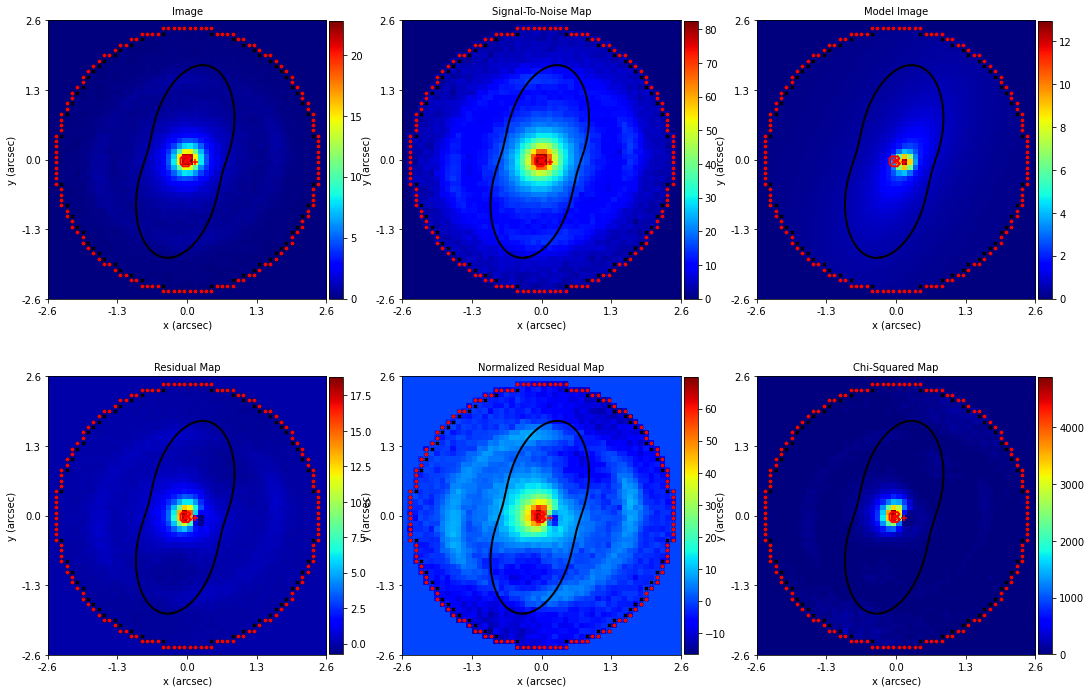

In [8]:
fit_imaging_plotter = aplt.FitImagingPlotter(
    fit=result_local_maxima.max_log_likelihood_fit
)
fit_imaging_plotter.subplot_fit_imaging()

Finally, just to be sure we hit a local maxima, lets compare the maximum log likelihood values of the two results 

The local maxima value is significantly lower, confirming that our non-linear search simply failed to locate lens 
models which fit the data better when it searched parameter space.

In [9]:
print("Likelihood of Global Model:")
print(result.max_log_likelihood_fit.log_likelihood)
print("Likelihood of Local Model:")
print(result_local_maxima.max_log_likelihood_fit.log_likelihood)

Likelihood of Global Model:
3563.5546185505455
Likelihood of Local Model:
-57061.33265451049


__Wrap Up__

In this example, we intentionally made our non-linear search fail, by using so few live points it had no hope of 
sampling parameter space thoroughly. For modeling real lenses we wouldn't do this intentionally, but the risk of 
inferring a local maxima is still very real, especially as we make our lens model more complex.

Lets think about *complexity*. As we make our lens model more realistic, we also made it more complex. For this 
tutorial, our non-linear parameter space went from 7 dimensions to 18. This means there was a much larger *volume* of 
parameter space to search. As this volume grows, there becomes a higher chance that our non-linear search gets lost 
and infers a local maxima, especially if we don't set it up with enough live points!

At its core, lens modeling is all about learning how to get a non-linear search to find the global maxima region of 
parameter space, even when the lens model is complex. This will be the main theme throughout the rest of this chapter
and is the main subject of chapter 3.

In the next exercise, we'll learn how to deal with failure and begin thinking about how we can ensure our non-linear 
search finds the global-maximum log likelihood solution. First, think about the following:

 1) When you look at an image of a strong lens, do you get a sense of roughly what values certain lens model 
 parameters are?
    
 2) The non-linear search failed because parameter space was too complex. Could we make it less complex, whilst 
 still keeping our lens model fairly realistic?
    
 3) The source galaxy in this example had only 7 non-linear parameters. Real source galaxies may have multiple 
 components (e.g. a disk, bulge, bar, star-forming knot) and there may even be more than 1 source galaxy! Do you 
 think there is any hope of us navigating a parameter space if the source contributes 20+ parameters by itself?